In [2]:
!pip install botorch
!pip install rdkit
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.3/530.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 12.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Binary Polymer Solution Cloud Point Database.csv')
df['Polymer Mols'] = df['Polymer SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df['Solvent Mols'] = df['Solvent SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df = df.dropna(0)

<ipython-input-4-b1f5684ff214>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna(0)


In [ ]:
df

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
0,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.12780,0.1202,4.73,-3.97,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f68fc8f7890>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f96d0>
1,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.17425,0.1644,4.44,-4.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f68fc919350>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f97b0>
2,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.19746,0.1866,0.48,-3.87,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f68fc919200>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f9740>
3,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,propionitrile,107-12-0,CCC#N,26700,1.05,0.09173,0.1100,2.28,172.28,negative,doi.org/10.1021/ma9517308,<rdkit.Chem.rdchem.Mol object at 0x7f68fc9193c0>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f9820>
4,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],85200,1.02,0.11958,0.1124,0.25,14.99,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f68fc919430>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f9890>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.5056,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f93c0>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7359e0>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.1159,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f9430>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc735a50>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.1394,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f94a0>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc735ac0>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.4083,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f9510>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc735b30>


In [ ]:
#Remove rows with polyetyrene-d8 (includes deuterium)
index_d_droped = df[(df["Polymer"] == "polystyrene-d8") | (df["Solvent"] == "nitroethane-d5")].index
df_new = df.drop(index_d_droped)
df_new

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
395,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.11406,0.15000,82.81,21.34,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f68fc8d0200>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc809820>
396,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.18196,0.23366,80.00,21.18,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f68fc8d0270>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc809890>
397,polystyrene,9003-53-6,*C(C*)c1ccccc1,cyclohexanol,108-93-0,OC1CCCCC1,78800,1.12,0.00632,0.00700,0.10,73.99,positive,doi.org/10.1021/je0504865,<rdkit.Chem.rdchem.Mol object at 0x7f68fc8d02e0>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc809900>
398,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclopentane,96-37-7,CC1CCCC1,22100,1.03,0.11401,0.15300,1.02,27.42,positive,doi.org/10.1021/ma00107a011,<rdkit.Chem.rdchem.Mol object at 0x7f68fc8d0350>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc809970>
399,polystyrene,9003-53-6,*C(C*)c1ccccc1,nitroethane,79-24-3,CC[N+](=O)[O-],13500,1.06,0.17990,0.17990,4.35,6.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f68fc8d03c0>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc8099e0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.50560,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f93c0>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7359e0>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.11590,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f9430>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc735a50>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.13940,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f94a0>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc735ac0>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.40830,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f68fc7f9510>,<rdkit.Chem.rdchem.Mol object at 0x7f68fc735b30>


# **Descriptor Calculation**

In [4]:
class Morgan_fingerprint(): #From Chen

    def __init__(self,mols):
        self.mols = mols
        self.bitExamples = {}
        self.keepMols = {}
        return

    def calculate(self,radius=2,bits=1024,vector_type="count",unhash=False):
        if vector_type not in ["count","bit"]:
            return
        elif vector_type=="bit":
            unhash=False
            fp_all = defaultdict()

        mols = self.mols
        self.bits = bits
        self.radius = radius
        self.bitI_morgan =  {}
        morgan_count = defaultdict(lambda:[0]*len(mols))
        for idx,mol in enumerate(tqdm(mols)):
            self.bitI_morgan[idx] = {}
            if unhash==True:
                fp_morgan = AllChem.GetMorganFingerprint(mol, radius, bitInfo=self.bitI_morgan[idx])
            else:
                fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius,
                                                                  bitInfo=self.bitI_morgan[idx],nBits=bits)
                if vector_type=="bit":
                    arr = np.zeros((1,))
                    DataStructs.ConvertToNumpyArray(fp_morgan, arr)
                    fp_all[idx]= arr
            for key in list(self.bitI_morgan[idx].keys()):
                morgan_count["{}".format(key)][idx]=len(self.bitI_morgan[idx][key])
                #generate bit examples for visualization
                self.bitExamples[key] = idx
                self.keepMols[idx]=mol

        if vector_type=="bit": return pd.DataFrame.from_dict(fp_all).T #Bit type
        return pd.DataFrame.from_dict(morgan_count)

    def visualize(self,bit_name,molSize=(250,200),verbose=True):
        bitId = int(bit_name)
        if verbose==True: print ('bit %s'%bitId)
        zid = self.bitExamples[bitId]
        mol = self.keepMols[zid]
        aid,rad = self.bitI_morgan[zid][bitId][0]
        pic1,svg  = getSubstructDepiction(mol,aid,rad,molSize=molSize)
        pic2 = Draw.DrawMorganBit(mol,bitId,self.bitI_morgan[zid])
        #display(pic)
        return pic1,pic2,svg

#for visualization #From Chen
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    #with open('morgan bits/%s.svg'%bitId, 'w') as f:
    #    f.write(svg)
    return SVG(svg.replace('svg:','')),svg

def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse)

In [ ]:
#MF for polymer
mf_poly = Morgan_fingerprint(df_new["Polymer Mols"].values)
fp_poly = mf_poly.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_poly = fp_poly.dropna(1)

#MF for solvent
mf_sol = Morgan_fingerprint(df_new["Solvent Mols"].values)
fp_sol = mf_sol.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_sol = fp_sol.dropna(1)

100%|██████████| 4833/4833 [00:00<00:00, 10517.71it/s]
<ipython-input-8-875bed0b3429>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  fp_poly = fp_poly.dropna(1)
100%|██████████| 4833/4833 [00:00<00:00, 14760.48it/s]
<ipython-input-8-875bed0b3429>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  fp_sol = fp_sol.dropna(1)


In [ ]:
fp_poly.head()

,1,64,80,170,175,226,247,341,356,389,...,566,587,863,875,103,578,658,770,932,968
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fp_sol.head()

,2,4,33,117,124,285,301,890,926,973,...,512,781,831,378,656,777,386,799,896,709
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Descriptor Combination (Poly_MF/Sol_MF)**

In [ ]:
fp_sol.columns

Index(['2', '4', '33', '117', '124', '285', '301', '890', '926', '973',
       ...
       '512', '781', '831', '378', '656', '777', '386', '799', '896', '709'],
      dtype='object', length=173)

In [ ]:
fp_sol_new = fp_sol.rename(columns=lambda n: n + '*')

In [ ]:
fp_sol_new

,2*,4*,33*,117*,124*,285*,301*,890*,926*,973*,...,512*,781*,831*,378*,656*,777*,386*,799*,896*,709*
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fp_com_mf = pd.concat([fp_poly, fp_sol_new, df_new.reset_index(drop=True)[["Mw(Da)", "PDI", "ϕ", "w", "P(Mpa)", "1-Phase", "CP(°C)"]]], axis=1)
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,positive,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,positive,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,positive,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,negative,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,negative,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,negative,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,negative,73.50


In [ ]:
#For 1-Phase, use LabelEncoder to transfer str to int.
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(fp_com_mf["1-Phase"])

fp_com_mf["1-Phase"] = LE.fit_transform(fp_com_mf["1-Phase"])
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,1,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,1,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,1,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,0,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,0,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,0,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,0,73.50


Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
f_std = fp_com_mf.copy()
f_std.loc[:, ["Mw(Da)", "P(Mpa)", "CP(°C)"]] = scaler.fit_transform(f_std.loc[:, ["Mw(Da)", "P(Mpa)", "CP(°C)"]])

In [ ]:
print(f_std.shape)
f_std.head()

(4833, 307)


,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.531646,1.06,0.11406,0.15000,5.774263,1,-0.763116
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.531646,1.06,0.18196,0.23366,5.564014,1,-0.765189
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.323328,1.12,0.00632,0.00700,-0.414228,1,-0.080926
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.516014,1.03,0.11401,0.15300,-0.345393,1,-0.684337
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.545239,1.06,0.17990,0.17990,-0.096237,1,-0.960841


# **Model Building**

In [ ]:
from sklearn.model_selection import train_test_split

X = f_std.iloc[:, :-1].values
y = f_std.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [ ]:
# A list for the evaluation result
rmse_sum = {}
r2_sum = {}

## Lasso

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, lasso.predict(X_train))
RMSE_train = mean_squared_error(y_train, lasso.predict(X_train), squared=False)
R_square_test = r2_score(y_test, lasso.predict(X_test))
RMSE_test = mean_squared_error(y_test, lasso.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.5869201156939176
RMSE(Train): 0.6448101810865128

R_square(Test): 0.6071495876727195
RMSE(Test): 0.6185089179411342


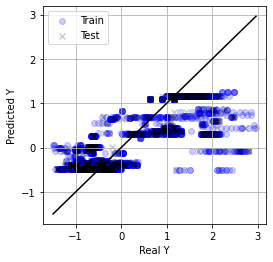

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, lasso.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, lasso.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['Linear Regression(Lasso)'] = [RMSE_train, RMSE_test]
r2_sum['Linear Regression(Lasso)'] = [R_square_train, R_square_test]

## Ridge

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, ridge.predict(X_train))
RMSE_train = mean_squared_error(y_train, ridge.predict(X_train), squared=False)
R_square_test = r2_score(y_test, ridge.predict(X_test))
RMSE_test = mean_squared_error(y_test, ridge.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.8410978898650057
RMSE(Train): 0.3999260511045725

R_square(Test): 0.8429025524490562
RMSE(Test): 0.3911262135530502


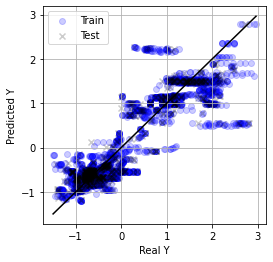

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, ridge.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, ridge.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['Linear Regression(Ridge)'] = [RMSE_train, RMSE_test]
r2_sum['Linear Regression(Ridge)'] = [R_square_train, R_square_test]

## ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.1)
EN.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, EN.predict(X_train))
RMSE_train = mean_squared_error(y_train, EN.predict(X_train), squared=False)
R_square_test = r2_score(y_test, EN.predict(X_test))
RMSE_test = mean_squared_error(y_test, EN.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.6295710767541289
RMSE(Train): 0.6106147730656183

R_square(Test): 0.6477070829853937
RMSE(Test): 0.5857122604538121


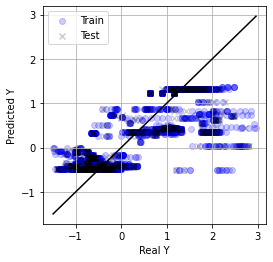

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, EN.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, EN.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['Linear Regression(ElasticNet)'] = [RMSE_train, RMSE_test]
r2_sum['Linear Regression(ElasticNet)'] = [R_square_train, R_square_test]

## RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, rf.predict(X_train))
RMSE_train = mean_squared_error(y_train, rf.predict(X_train), squared=False)
R_square_test = r2_score(y_test, rf.predict(X_test))
RMSE_test = mean_squared_error(y_test, rf.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9995764030184022
RMSE(Train): 0.020648632321158274

R_square(Test): 0.9978892176420993
RMSE(Test): 0.04533713655014804


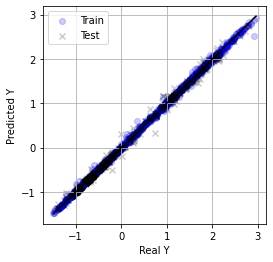

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, rf.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, rf.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['RF'] = [RMSE_train, RMSE_test]
r2_sum['RF'] = [R_square_train, R_square_test]

## SVR

In [ ]:
# from sklearn.svm import SVR
# svr = SVR()
# svr.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, svr.predict(X_train))
# RMSE_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, svr.predict(X_test))
# RMSE_test = mean_squared_error(y_test, svr.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, svr.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [ ]:
# rmse_sum['SVR'] = [RMSE_train, RMSE_test]
# r2_sum['SVR'] = [R_square_train, R_square_test]

## XGB

In [ ]:
# import xgboost as xgb
# xgb_reg = xgb.XGBRegressor()
# params = {'metric':'rmse',
#           'objective':'reg:squarederror',
#           'n_estimators':5000,
#           'booster': 'gbtree',
#           'learning_rate':0.01,
#           'min_child_weight':1,
#           'max_depth':5,
#           'random_state':0,
#           'colsample_bytree':1,
#           'subsample':1,
#          }
# xgb_reg.set_params(**params)
# xgb_reg.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, xgb_reg.predict(X_train))
# RMSE_train = mean_squared_error(y_train, xgb_reg.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, xgb_reg.predict(X_test))
# RMSE_test = mean_squared_error(y_test, xgb_reg.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, xgb_reg.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, xgb_reg.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [ ]:
# rmse_sum['XGBoost'] = [RMSE_train, RMSE_test]
# r2_sum['XGBoost'] = [R_square_train, R_square_test]

## GpyTorch

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# X must be in the range=(0, 1)
# use MinMaxScaler to transform features
mmscaler = MinMaxScaler()
X_train_mm = mmscaler.fit_transform(X_train)
X_test_mm = mmscaler.transform(X_test)


X_train_tensor = torch.from_numpy(np.array(X_train_mm))
X_test_tensor = torch.from_numpy(np.array(X_test_mm))


# Y must be in the range=(-1, 1)
y_scaler = StandardScaler()

y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_s = y_scaler.transform(y_test.reshape(-1, 1))

y_train_tensor = torch.from_numpy(np.array(y_train_s))
y_test_tensor = torch.from_numpy(np.array(y_test_s))

In [ ]:
kernel = RBFKernel(ard_num_dims=X.shape[1])

gp = SingleTaskGP(X_train_tensor, y_train_tensor, covar_module=kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_train_pred = gp.posterior(X_train_tensor).mean.detach().numpy().copy()
y_train_var = gp.posterior(X_train_tensor).variance.detach().numpy().copy()

y_test_pred = gp.posterior(X_test_tensor).mean.detach().numpy().copy()
y_test_var = gp.posterior(X_test_tensor).variance.detach().numpy().copy()

R_square_train = r2_score(y_train_s, y_train_pred)
RMSE_train = mean_squared_error(y_scaler.inverse_transform(y_train_s), y_scaler.inverse_transform(y_train_pred), squared=False)
R_square_test = r2_score(y_test_s, y_test_pred)
RMSE_test = mean_squared_error(y_scaler.inverse_transform(y_test_s), y_scaler.inverse_transform(y_test_pred), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9757209219717258
RMSE(Train): 0.15632590735579566

R_square(Test): 0.9743813873833509
RMSE(Test): 0.15794655670595015


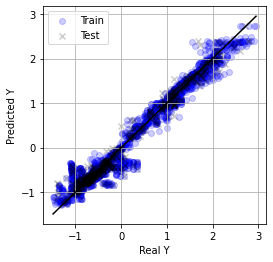

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train_s, y_train_pred, alpha=0.2, c="blue", label='Train')
plt.scatter(y_test_s, y_test_pred, alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train_s.min(), y_train_s.max()], [y_train_s.min(), y_train_s.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['GP'] = [RMSE_train, RMSE_test]
r2_sum['GP'] = [R_square_train, R_square_test]

# **Summary**

In [ ]:
summary = pd.DataFrame(rmse_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of RMSE")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train,0.644810,0.399926,0.610615,0.020649,0.156326
Test,0.618509,0.391126,0.585712,0.045337,0.157947


In [ ]:
summary = pd.DataFrame(r2_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of R square")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train,0.586920,0.841098,0.629571,0.999576,0.975721
Test,0.607150,0.842903,0.647707,0.997889,0.974381


# **Feature Importance**

Text(0.5, 0, 'Feature Importance')

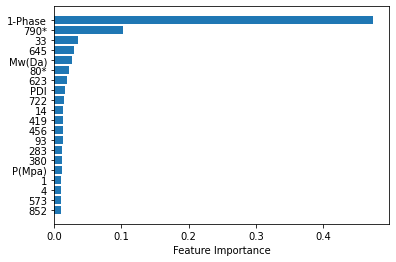

In [ ]:
sort = rf.feature_importances_.argsort()
plt.barh(fp_com_mf.iloc[:, :-1].columns[sort].astype(str)[-20:], rf.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

For Solvent
bit 790


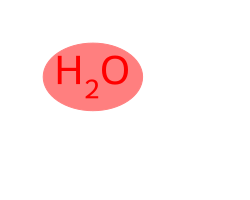

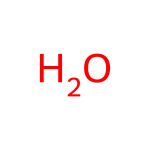

For Polymer
bit 33


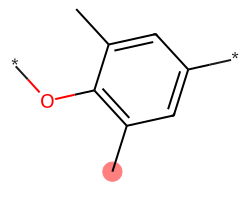

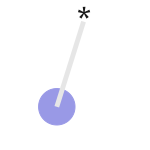

For Polymer
bit 645


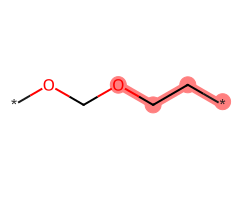

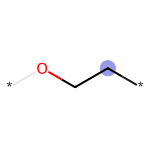

For Solvent
bit 80


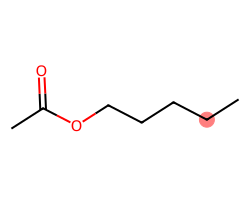

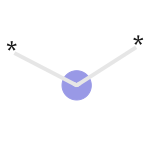

In [ ]:
#Draw top ranking Morgan fingerpirnt
from IPython.core.display import display

bits = ["790*", 33, 645, "80*"]
for bit in bits:
  if type(bit) is int:
    print("For Polymer")
    pic1,pic2,_ = mf_poly.visualize(bit)
    display(pic1, pic2)

  else:
    print("For Solvent")
    pic1,pic2,_ = mf_sol.visualize(int(bit[:-1]))
    display(pic1, pic2)

model_output = "margin" has been renamed to model_output = "raw"


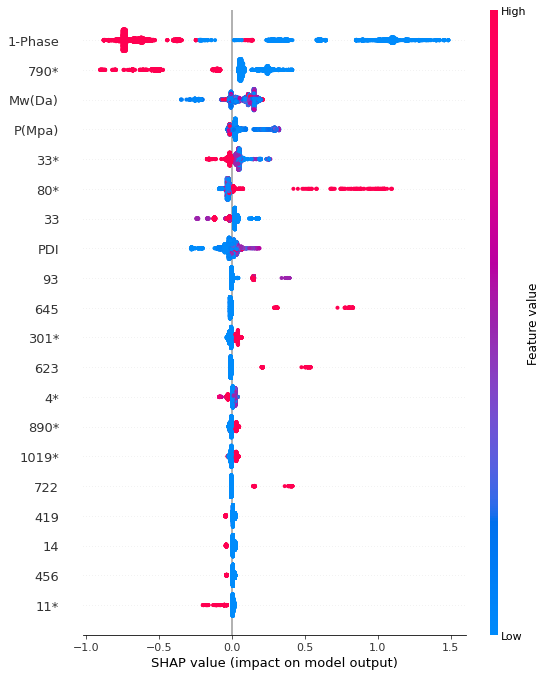

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=fp_com_mf.iloc[:, :-1])
shap.summary_plot(shap_values, fp_com_mf.iloc[:, :-1])

# **Feature Selection**

Low Variance Filter

In [ ]:
from copy import copy

thresheld = 0.1  #10%

data = copy(pd.DataFrame(X)) #only check X variables
var = data.var()
X_col = data.columns
variable = X_col[var >=thresheld] #find columns to keep
data = data[variable]

print (data.shape)

(4833, 62)


High Correlation Filter

In [ ]:
#Filter Method is the first step to perform when selecting features.
from copy import copy

thresheld = 0.8

# data = copy(fp_com) #Stacking with low variance filter
corr_matrix = data.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #using 'where' and input array to choose a specific cell in dataframe
to_drop = [column for column in upper.columns if any(upper[column] >= thresheld)] #find columns to drop
data = data.drop(columns = to_drop)

print (data.shape)

(4833, 28)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
data.to_csv('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Training Data/Feature selected data(MF_MF_Full data).csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split

X = data.values
y = df_new["CP(°C)"].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

#Using randomforestregressor
rf_new = RandomForestRegressor()
rf_new.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, rf_new.predict(X_train))
RMSE_train = mean_squared_error(y_train, rf_new.predict(X_train), squared=False)
R_square_test = r2_score(y_test, rf_new.predict(X_test))
RMSE_test = mean_squared_error(y_test, rf_new.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9968371121291318
RMSE(Train): 4.330228223758278

R_square(Test): 0.9912177869152966
RMSE(Test): 7.1234415783605955


In [ ]:
rmse_sum['RF_feature selected'] = [RMSE_train, RMSE_test]
r2_sum['RF_feature selected'] = [R_square_train, R_square_test]

Text(0.5, 0, 'Feature Importance')

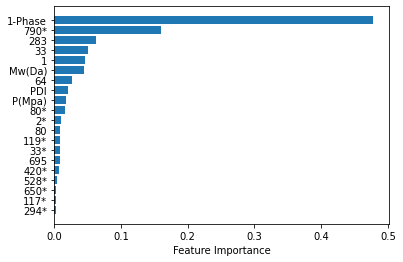

In [ ]:
sort = rf_new.feature_importances_.argsort()
plt.barh(data.columns[sort].astype(str)[-20:], rf_new.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

For Solvent
bit 790


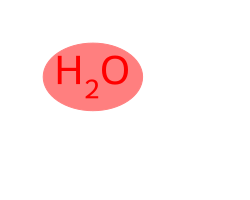

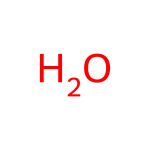

For Polymer
bit 283


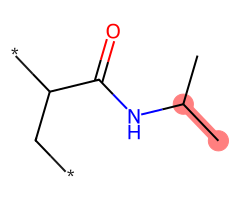

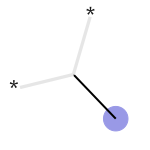

For Polymer
bit 33


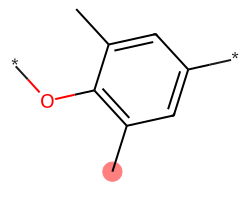

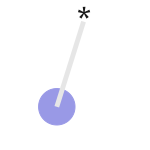

For Polymer
bit 1


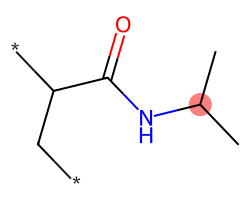

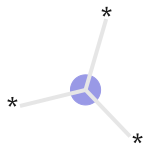

For Polymer
bit 64


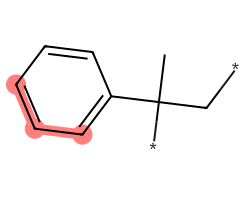

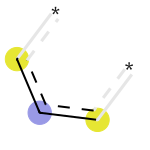

In [ ]:
#Draw top ranking Morgan fingerpirnt
from IPython.core.display import display

bits = ["790*", 283, 33, 1, 64]
for bit in bits:
  if type(bit) is int:
    print("For Polymer")
    pic1,pic2,_ = mf_poly.visualize(bit)
    display(pic1, pic2)

  else:
    print("For Solvent")
    pic1,pic2,_ = mf_sol.visualize(int(bit[:-1]))
    display(pic1, pic2)

# **Bayesian Optimization**

## Analytic Acquisition Function

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

bounds = torch.stack([torch.zeros(310), torch.ones(310)])

candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)

print(candidate)
print(acq_value)

tensor([[0.6079, 0.1953, 0.5178, 0.5051, 0.7998, 0.8529, 0.5271, 0.0727, 0.6454,
         0.9259, 0.9154, 0.9938, 0.4107, 0.5631, 0.1763, 0.8222, 0.4232, 0.5241,
         0.2439, 0.0283, 0.5779, 0.4815, 0.7374, 0.4056, 0.4219, 0.4654, 0.1619,
         0.8422, 0.8027, 0.7063, 0.9157, 0.0380, 0.2475, 0.1264, 0.1566, 0.6084,
         0.6828, 0.0991, 0.6402, 0.1795, 0.2289, 0.7653, 0.0036, 0.3499, 0.4612,
         0.8390, 0.8910, 0.7253, 0.5783, 0.1162, 0.7685, 0.7909, 0.1302, 0.9242,
         0.8255, 0.2513, 0.8238, 0.6873, 0.2300, 0.7769, 0.6904, 0.8598, 0.2780,
         0.3449, 0.0513, 0.5832, 0.8087, 0.5754, 0.3983, 0.6823, 0.5796, 0.3681,
         0.8422, 0.5483, 0.1274, 0.5166, 0.1231, 0.6770, 0.1708, 0.8215, 0.8701,
         0.7079, 0.0578, 0.3226, 0.7066, 0.7453, 0.9357, 0.5031, 0.6489, 0.4337,
         0.6743, 0.7755, 0.8808, 0.5073, 0.6326, 0.6654, 0.3618, 0.6569, 0.7638,
         0.4405, 0.4084, 0.3459, 0.2944, 0.7386, 0.6177, 0.6475, 0.9568, 0.3197,
         0.7536, 0.7254, 0.7

## Monte-Carlo Acquisition Function

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import qUpperConfidenceBound

qUCB = qUpperConfidenceBound(gp, beta=0.1)

bounds = torch.stack([torch.zeros(310), torch.ones(310)])

candidate, acq_value = optimize_acqf(
    qUCB, bounds=bounds, q=5, num_restarts=5, raw_samples=20, sequential=True
)

print(candidate)
print(acq_value)

tensor([[0.5350, 0.4567, 0.2154,  ..., 0.7444, 0.6585, 0.6162],
        [0.2426, 0.1041, 0.0904,  ..., 0.2900, 0.2782, 0.2742],
        [0.4816, 0.9507, 0.7875,  ..., 0.8367, 0.1469, 0.2812],
        [0.3732, 0.7665, 0.4030,  ..., 0.8335, 0.3265, 0.0354],
        [0.6453, 0.6621, 0.9993,  ..., 0.7832, 0.0707, 0.2988]])
tensor([0.3826, 0.5137, 0.5916, 0.6487, 0.6842], dtype=torch.float64)
